Falling back to backtracking search...
Costas permutation for N=15:
[ 1  2  6 14  9  3 15 13  5 10 12 11  8  4  7]


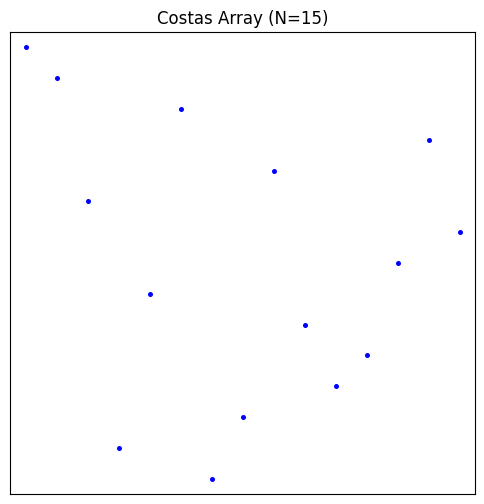

In [8]:
from costas import generate_costas_array, visualize_costas_array

# Example usage
if __name__ == "__main__":
    N = 15  # Change to desired size
    result = generate_costas_array(N)
    if result is not None:
        print(f"Costas permutation for N={N}:")
        print(result + 1)  # Convert 0-based to 1-based indexing
    visualize_costas_array(result)

Epoch 10/200, Loss = 1.1683
Epoch 20/200, Loss = 0.9305
Epoch 30/200, Loss = 0.8549
Epoch 40/200, Loss = 0.8188
Epoch 50/200, Loss = 0.8006
Epoch 60/200, Loss = 0.7947
Epoch 70/200, Loss = 0.7930
Epoch 80/200, Loss = 0.7925
Epoch 90/200, Loss = 0.7924
Epoch 100/200, Loss = 0.7920
Epoch 110/200, Loss = 0.7913
Epoch 120/200, Loss = 0.7913
Epoch 130/200, Loss = 0.7912
Epoch 140/200, Loss = 0.7912
Epoch 150/200, Loss = 0.7911
Epoch 160/200, Loss = 0.7911
Epoch 170/200, Loss = 0.7909
Epoch 180/200, Loss = 0.7906
Epoch 190/200, Loss = 0.7905
Epoch 200/200, Loss = 0.7904

Neural-Net-Stitched Permutation (0-based columns):
[ 1 20 29 14  0  6 13  2 18 14  8 21 15  6 27  9  0 22  1  2 25 29 13 17
 28  0 25 12  0  2]


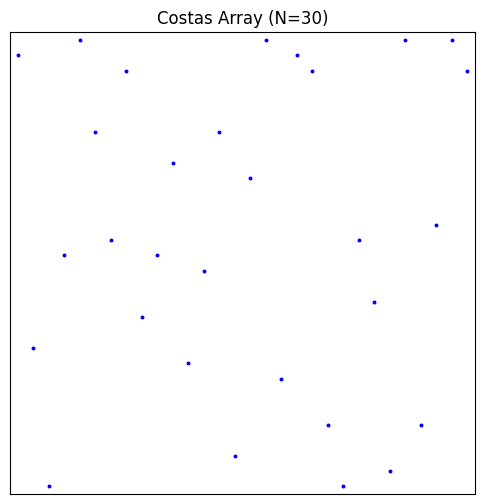

In [17]:
import math
import numpy as np
from numba import njit
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# 1. Existing Costas-Array Code (as provided)
# -------------------------------------------------------------------------
@njit
def is_prime(n):
    if n < 2:
        return False
    if n % 2 == 0:
        return n == 2
    for x in range(3, int(n**0.5) + 1, 2):
        if n % x == 0:
            return False
    return True

@njit
def powmod(base, exp, mod):
    result = 1
    while exp > 0:
        if exp & 1:
            result = (result * base) % mod
        base = (base * base) % mod
        exp >>= 1
    return result

@njit
def find_primitive_root(p):
    phi = p - 1
    factors = []
    temp = phi
    for f in range(2, int(temp**0.5) + 1):
        if temp % f == 0:
            factors.append(f)
            while temp % f == 0:
                temp //= f
    if temp > 1:
        factors.append(temp)

    for g in range(2, p):
        for factor in factors:
            if powmod(g, phi // factor, p) == 1:
                break
        else:
            return g
    return -1

@njit
def welch_costas(n):
    """ Returns a permutation of size n if n+1 is prime; else None. """
    p = n + 1
    if not is_prime(p):
        return None
    g = find_primitive_root(p)
    if g < 0:
        return None
    perm = np.empty(n, dtype=np.int64)
    cur = 1
    for i in range(n):
        cur = (cur * g) % p
        perm[i] = cur - 1
    return perm

@njit
def _search_costas(permutation, used_col, used_diffs, row, N):
    if row == N:
        return True
    for col in range(N):
        if not used_col[col]:
            valid = True
            for rprev in range(row):
                rdiff = row - rprev
                cdiff = col - permutation[rprev] + N - 1
                if used_diffs[rdiff, cdiff]:
                    valid = False
                    break
            if valid:
                permutation[row] = col
                used_col[col] = True
                for rprev in range(row):
                    rdiff = row - rprev
                    cdiff = col - permutation[rprev] + N - 1
                    used_diffs[rdiff, cdiff] = True

                if _search_costas(permutation, used_col, used_diffs, row + 1, N):
                    return True

                used_col[col] = False
                for rprev in range(row):
                    rdiff = row - rprev
                    cdiff = col - permutation[rprev] + N - 1
                    used_diffs[rdiff, cdiff] = False
    return False

@njit
def costas_array_backtracking(N):
    if N == 1:
        return np.array([0], dtype=np.int64)
    permutation = np.full(N, -1, dtype=np.int64)
    used_col = np.zeros(N, dtype=np.bool_)
    used_diffs = np.zeros((N, 2*N - 1), dtype=np.bool_)
    if _search_costas(permutation, used_col, used_diffs, 0, N):
        return permutation
    return None

@njit
def generate_costas_array_njit(N):
    if N < 1:
        return None
    permutation = welch_costas(N)
    if permutation is not None:
        return permutation
    # fallback
    return costas_array_backtracking(N)

def generate_costas_array(N):
    result = generate_costas_array_njit(N)
    if result is not None:
        if welch_costas(N) is not None:
            print("Generated using Welch method.")
        else:
            print("Falling back to backtracking search...")
    return result

def visualize_costas_array(permutation):
    if permutation is None:
        print("No Costas array to display.")
        return
    N = len(permutation)
    plt.figure(figsize=(6, 6))
    plt.scatter(np.arange(N) + 0.5, permutation + 0.5, color='blue', s=100 / N)
    plt.xlim(0, N)
    plt.ylim(0, N)
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Costas Array (N={N})")
    plt.show()

# -------------------------------------------------------------------------
# 2. "Prime Factor + Neural Network" Attempt
# -------------------------------------------------------------------------

def factor_int(n):
    """Naive integer factorization (for demonstration)."""
    # In practice, you might call a better factorization or Shor's algorithm
    factors = []
    # Check divisibility by 2
    while n % 2 == 0:
        factors.append(2)
        n //= 2
    # Check odd factors
    f = 3
    while f * f <= n:
        while n % f == 0:
            factors.append(f)
            n //= f
        f += 2
    if n > 1:
        factors.append(n)
    return factors

def get_subarrays_from_prime_factors(n):
    """Generate Welch Costas arrays for each prime factor p => p-1."""
    factors = factor_int(n)
    sub_arrays = []
    for p in factors:
        sub_n = p - 1
        wc = welch_costas(sub_n)
        if wc is not None:
            sub_arrays.append(wc)
        else:
            # Could fallback to backtracking or skip
            sub_arrays.append(np.array([], dtype=np.int64))
    return sub_arrays

# -- Simple MLP to try to form an Nx array from prime-based subarrays --
class StitcherNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, N):
        super().__init__()
        self.N = N
        # We'll produce a "logit" for each row, for each possible column
        # e.g. output shape (N, N), then we pick an argmax in each row
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, N*N)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        h = torch.relu(self.fc1(x))
        out = self.fc2(h)  # shape: (batch_size, N*N)
        # We can reshape to (batch_size, N, N)
        out = out.view(-1, self.N, self.N)
        return out

def costas_loss(pred_array):
    """
    A 'soft' loss that penalizes repeated differences.
    pred_array: shape (batch, N, N).
      We'll interpret row i's distribution as which column is chosen.
      We'll do a "soft" argmax with row i's distribution.
    This is purely a demonstration— discrete constraints are tricky.
    """
    batch_size, N, _ = pred_array.shape

    # Convert row distributions into a 'column index' in a differentiable way,
    # e.g. softmax -> column "probabilities"
    row_probs = torch.softmax(pred_array, dim=2)  # shape (batch, N, N)

    # We can sample or do an expected dot. We'll do an "expected column index"
    columns = torch.arange(N).to(pred_array.device)
    # shape: (N)
    # shape after unsqueeze & broadcast => (1, 1, N)
    col_indices = (row_probs * columns.unsqueeze(0).unsqueeze(0)).sum(dim=2)
    # shape: (batch, N) is the "soft" column index for each row

    total_loss = 0.0
    for b in range(batch_size):
        # We'll measure repeated distances in a (N, 2*N-1) boolean style, but in a soft sense
        perm = col_indices[b]  # shape: (N,)
        # For each pair (i, j), i < j, check the vector difference
        # i-j, perm[i]-perm[j]
        # We'll do a simple penalty if differences are close

        # We can't do a direct discrete check, so let's do a "soft collision" measure:
        pair_count = 0
        collision_penalty = 0.0
        for i in range(N):
            for j in range(i+1, N):
                rdiff = j - i
                cdiff = perm[j] - perm[i]
                # We want distinct (rdiff, cdiff) for every pair
                # We'll measure closeness to other pairs
                # This is O(N^2) which might be slow for large N
                for k in range(N):
                    for l in range(k+1, N):
                        if (k, l) != (i, j):
                            rdiff2 = l - k
                            cdiff2 = col_indices[b,l] - col_indices[b,k]
                            # If (rdiff, cdiff) is "close" to (rdiff2, cdiff2),
                            # penalize
                            dist = ((rdiff - rdiff2)**2 + (cdiff - cdiff2)**2)
                            # We want dist > 0 ideally
                            # If dist is near 0, penalize
                            collision_penalty += torch.exp(-dist)
                pair_count += 1

        # Combine
        total_loss += collision_penalty / (pair_count + 1e-6)

    return total_loss / batch_size

def stitch_arrays_with_nn(n, epochs=100, lr=1e-2, hidden_dim=128):
    """
    Attempt to create an NxN Costas array by combining prime-based sub-arrays
    and letting a neural net produce a (soft) permutation.
    """
    # 1. Gather sub-arrays for prime factors
    sub_arrays = get_subarrays_from_prime_factors(n)
    # Flatten & concatenate them into a single feature vector
    # Just one example of an encoding; many other ways possible.
    feats = []
    for arr in sub_arrays:
        if len(arr) > 0:
            # normalize by length
            arr_norm = arr / (len(arr)+1)
            feats.extend(list(arr_norm))
        else:
            feats.extend([0.0])  # placeholder if no array
    input_vec = torch.tensor(feats, dtype=torch.float32).unsqueeze(0)  # shape (1, input_dim)
    input_dim = input_vec.shape[1]

    # 2. Initialize the neural net
    model = StitcherNet(input_dim, hidden_dim, n)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 3. Training loop
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(input_vec)  # shape: (1, N, N)
        loss = costas_loss(out)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.4f}")

    # 4. Get final "soft" solution
    model.eval()
    with torch.no_grad():
        out = model(input_vec)  # (1, N, N)
        row_probs = torch.softmax(out, dim=2)  # (1, N, N)
        # final integer columns
        col_indices = row_probs[0].argmax(dim=1)  # shape: (N,)
    return col_indices.cpu().numpy()

# -------------------------------------------------------------------------
# 3. Running an Example
# --------------------------------------------------------------------P-----
if __name__ == "__main__":
    N = 30  # Example composite number
    # Stitch sub-arrays with a small neural net:
    stitched_perm = stitch_arrays_with_nn(N, epochs=200, lr=5e-2, hidden_dim=64)
    print("\nNeural-Net-Stitched Permutation (0-based columns):")
    print(stitched_perm)

    # Visualize the stitched result
    visualize_costas_array(stitched_perm)

In [18]:
@njit
def is_valid_costas(array):
    """
    Check if the given array is a valid Costas array.

    Parameters:
    array (numpy.ndarray): A 1D or 2D representation of a Costas array.
        - If 1D: An array representing the permutation of the columns.
        - If 2D: A binary matrix with 1s representing the "dots" of the array.

    Returns:
    bool: True if the array is a valid Costas array, False otherwise.
    """
    if array.ndim == 1:
        # 1D permutation representation
        N = len(array)
        if len(set(array)) != N or np.any(array < 0) or np.any(array >= N):
            return False  # Invalid permutation

        # Convert to binary matrix for easier displacement checking
        binary_matrix = np.zeros((N, N), dtype=np.int64)
        for i in range(N):
            binary_matrix[i, array[i]] = 1

    elif array.ndim == 2:
        # 2D binary matrix representation
        binary_matrix = array
        N = binary_matrix.shape[0]
        if binary_matrix.shape[1] != N:
            return False  # Must be square

        # Check if each row and column has exactly one "1"
        if not np.all(binary_matrix.sum(axis=0) == 1) or not np.all(binary_matrix.sum(axis=1) == 1):
            return False
    else:
        return False  # Invalid input format

    # Check displacement vectors for distinctness
    positions = np.argwhere(binary_matrix == 1)  # Get row-column coordinates of dots
    num_positions = len(positions)
    displacements = set()

    for i in range(num_positions):
        for j in range(i + 1, num_positions):
            r_diff = positions[j, 0] - positions[i, 0]
            c_diff = positions[j, 1] - positions[i, 1]
            displacement = (r_diff, c_diff)

            if displacement in displacements:
                return False  # Repeated displacement vector

            displacements.add(displacement)

    return True

In [19]:
is_valid_costas(stitched_perm), is_valid_costas(generate_costas_array(30))

Generated using Welch method.


(False, True)